In [1]:
from glob import glob
import numpy as np
import pandas as pd
from PIL import Image
import os

In [2]:
im_files = glob('/contents/images/*.jpg')
print(len(im_files))

1617


In [3]:
image_shape = np.array(Image.open(im_files[0])).shape

In [4]:
image_shapes = np.array([np.array(Image.open(i)).shape for i in im_files])
print(np.unique(image_shapes[:,0])) #rows vary between 960 and 976
#images vary a great deal in shape, so we need to standardize...
#go small for now so things are easier
#try to use 1000 images to utilize unsupervised learning to find out if seasons are 
#detectable features. Then we want to see where the image lies on the feature space?
#other spaces are like seasonal conditions of cloudy and such

[960 976]


(512, 400)


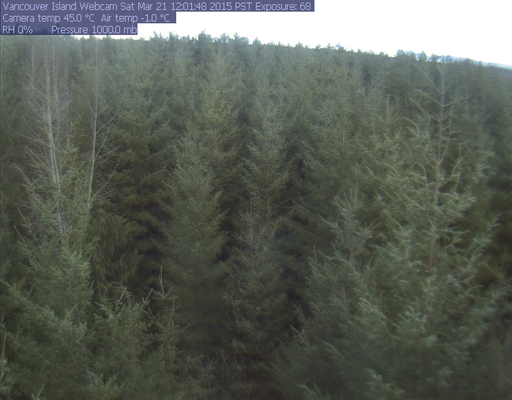

In [14]:
'''
basewidth = 512 
baseheight = 400 

img = Image.open(im_files[0])
img = img.resize((basewidth,baseheight), Image.ANTIALIAS)
print(img.size)
img
'''

In [15]:
#####RESIZE ALL IMAGES
#basewidth = 256 
#baseheight = 192
basewidth = 256*2 
baseheight = 192*2
#wpercent = (basewidth/float(img.size[i]))
#hsize = int((float(img.size[1])*float(wpercent)))
#img = img.resize((basewidth,hsize), Image.ANTIALIAS)
for im in im_files:
    img = Image.open(im)
    img = img.resize((basewidth,baseheight), Image.ANTIALIAS)
    thumbnail_path = '/contents/images/thumbnail'
    f = os.path.basename(im)
    new_path = '%s/%s'%(thumbnail_path, f)
    img.save(new_path) 

In [16]:
im_files = glob('/contents/images/thumbnail/*.jpg')
print(len(im_files))

1617


In [17]:
#get the images and put them in a single x_train and x_test array
imgs = np.array([np.array(Image.open(i)) for i in im_files])
dates = np.array([int(i.split('_')[2]) for i in im_files])

In [18]:
#get a random sample
#make data
training_perc = 0.9
n = int(len(imgs)*training_perc)
np.random.seed(1234)
idx = np.random.permutation(len(imgs))
x_train = imgs[idx[:n]]/255.
x_test = imgs[idx[n:]]/255.
#we will use the month as the class 
# or y variable
y_train = dates[idx[:n]]
y_test = dates[idx[n:]]


In [19]:
#input parameters
img_rows, img_cols, img_chns = x_train[0].shape
latent_dim = 3
intermediate_dim = 128 
epsilon_std = 1.0
epochs = 60 
filters = 32
num_conv = 3
batch_size = 60 

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D
from keras.models import Model
from keras import backend as K
from keras import metrics

# import parameters

# tensorflow uses channels_last
# theano uses channels_first
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [21]:
# encoder architecture
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

# mean and variance for latent variables
z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)


In [22]:
# sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [23]:
# decoder architecture
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(int(filters * img_rows / 2 * img_cols / 2), activation='relu')

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, int(img_rows / 2), int(img_cols / 2))
else:
    output_shape = (batch_size, int(img_rows / 2), int(img_cols / 2), filters)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)



In [24]:
# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean_squash)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariationalLayer()([x, x_decoded_mean_squash])


In [25]:
# entire model
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 384, 512, 3)  39          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 192, 256, 3)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 96, 128, 32)  416         max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
history = vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))


Train on 1455 samples, validate on 162 samples
Epoch 1/60
1455/1455 [==============================] - 64s 44ms/step - loss: 436510.9888 - val_loss: 121169.6409
Epoch 2/60
1455/1455 [==============================] - 56s 38ms/step - loss: 115356.0337 - val_loss: 113319.9844
Epoch 3/60
1455/1455 [==============================] - 56s 39ms/step - loss: 111835.1651 - val_loss: 110869.0608
Epoch 4/60
1455/1455 [==============================] - 56s 39ms/step - loss: 111092.7995 - val_loss: 111241.2940
Epoch 5/60
1455/1455 [==============================] - 56s 38ms/step - loss: 110793.9986 - val_loss: 110636.3189
Epoch 6/60
1455/1455 [==============================] - 56s 39ms/step - loss: 110028.4667 - val_loss: 109512.3880
Epoch 7/60
1455/1455 [==============================] - 56s 39ms/step - loss: 109398.9757 - val_loss: 109375.4780
Epoch 8/60
1455/1455 [==============================] - 56s 39ms/step - loss: 108414.6008 - val_loss: 108022.9635
Epoch 9/60
1455/1455 [===================

In [27]:
# encoder from learned model
encoder = Model(x, z_mean)

# generator / decoder from learned model
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

# save all 3 models for future use - especially generator
vae.save('/contents/models/pheno_ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (latent_dim, num_conv, intermediate_dim, epochs))
encoder.save('/contents/models/pheno_ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (latent_dim, num_conv, intermediate_dim, epochs))
generator.save('/contents/models/pheno_ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (latent_dim, num_conv, intermediate_dim, epochs))


In [28]:
# save training history
import pickle
fname = '/contents/models/pheno_ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (latent_dim, num_conv, intermediate_dim, epochs)
with open(fname, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)